In [64]:
# Carrie Lei & Diana Cantini
# Final Project: Phased Array Antenna Simulation

# Milestone 1 Goal: Read-up on phased arrays & math behind it + 1D Array Simulation
# To be implemented next: phase shifted input current sources; writing a better function to easily simulate multiple antennas in a row; NTFF transformations

In [65]:
import matplotlib.pyplot as plt
import math
import numpy as np

# Simulation Parameters
e0 = 1        
mu0 = 1       
c0 = 1 / math.sqrt(e0 * mu0) 
dx = 0.5e-3 
dy = 0.5e-3 
magic_time_step = dx / (np.sqrt(2) * c0)
max_time_steps = 500

# Grid in cell units
whole_grid = 100e-3 # whole grid = 30 mm
numX_cells = int(whole_grid / dx)  
numY_cells = int(whole_grid / dy)   
center_x = numX_cells // 2
center_y = numY_cells // 2

# Set up the permittivity grid 
grid = np.ones((numY_cells, numX_cells)) * e0

# Source locations
dipole_spacing_cells = int(15e-3 / dx) # cells between dipoles
x1_source = center_x - (dipole_spacing_cells //2)
x2_source = center_x + (dipole_spacing_cells//2)
y1_source = center_y
y2_source = center_y

# Source parameters
lambda0 = 6e-2 # wavelength for 5G is 6 cm
lambda_lower = 5e-2
lambda_upper = 7e-2
omega0 = (2 * np.pi * c0) / lambda0
sigma = (2 / omega0) * (lambda0 / (lambda_upper - lambda_lower))

# Arrays to store fields
Ez = np.zeros((numX_cells, numY_cells))
Hx = np.zeros((numX_cells, numY_cells))
Hy = np.zeros((numX_cells, numY_cells))

In [66]:
# Dipole Simulation

e_dipole = 100 # permitivity of copper is close to infinity
dipole_width = 1e-3 # dipole thickness = 1 mm
dipole_height = 15e-3 # dipole height = 15 mm
dipole_width_cells = int(dipole_width / dx)         
dipole_height_cells = int(dipole_height / dy)  

# Dipole locations
dipole1_center = x1_source
dipole1_left = dipole1_center - (dipole_width_cells // 2)
dipole1_right = dipole1_left + dipole_width_cells - 1
dipole1_bottom = center_y - (dipole_height_cells // 2)
dipole1_top = dipole1_bottom + dipole_height_cells - 1

dipole2_center = x2_source
dipole2_left = dipole2_center - (dipole_width_cells // 2)
dipole2_right = dipole2_left + dipole_width_cells - 1
dipole2_bottom = center_y - (dipole_height_cells // 2)
dipole2_top = dipole2_bottom + dipole_height_cells - 1

# Place left dipole in permittivity grid
for x in range(dipole1_left, dipole1_right + 1):
    for y in range(dipole1_bottom, dipole1_top + 1):
        grid[y, x] = e_dipole

# Place right dipole in permittivity grid
for x in range(dipole2_left, dipole2_right + 1):
    for y in range(dipole2_bottom, dipole2_top + 1):
        grid[y, x] = e_dipole

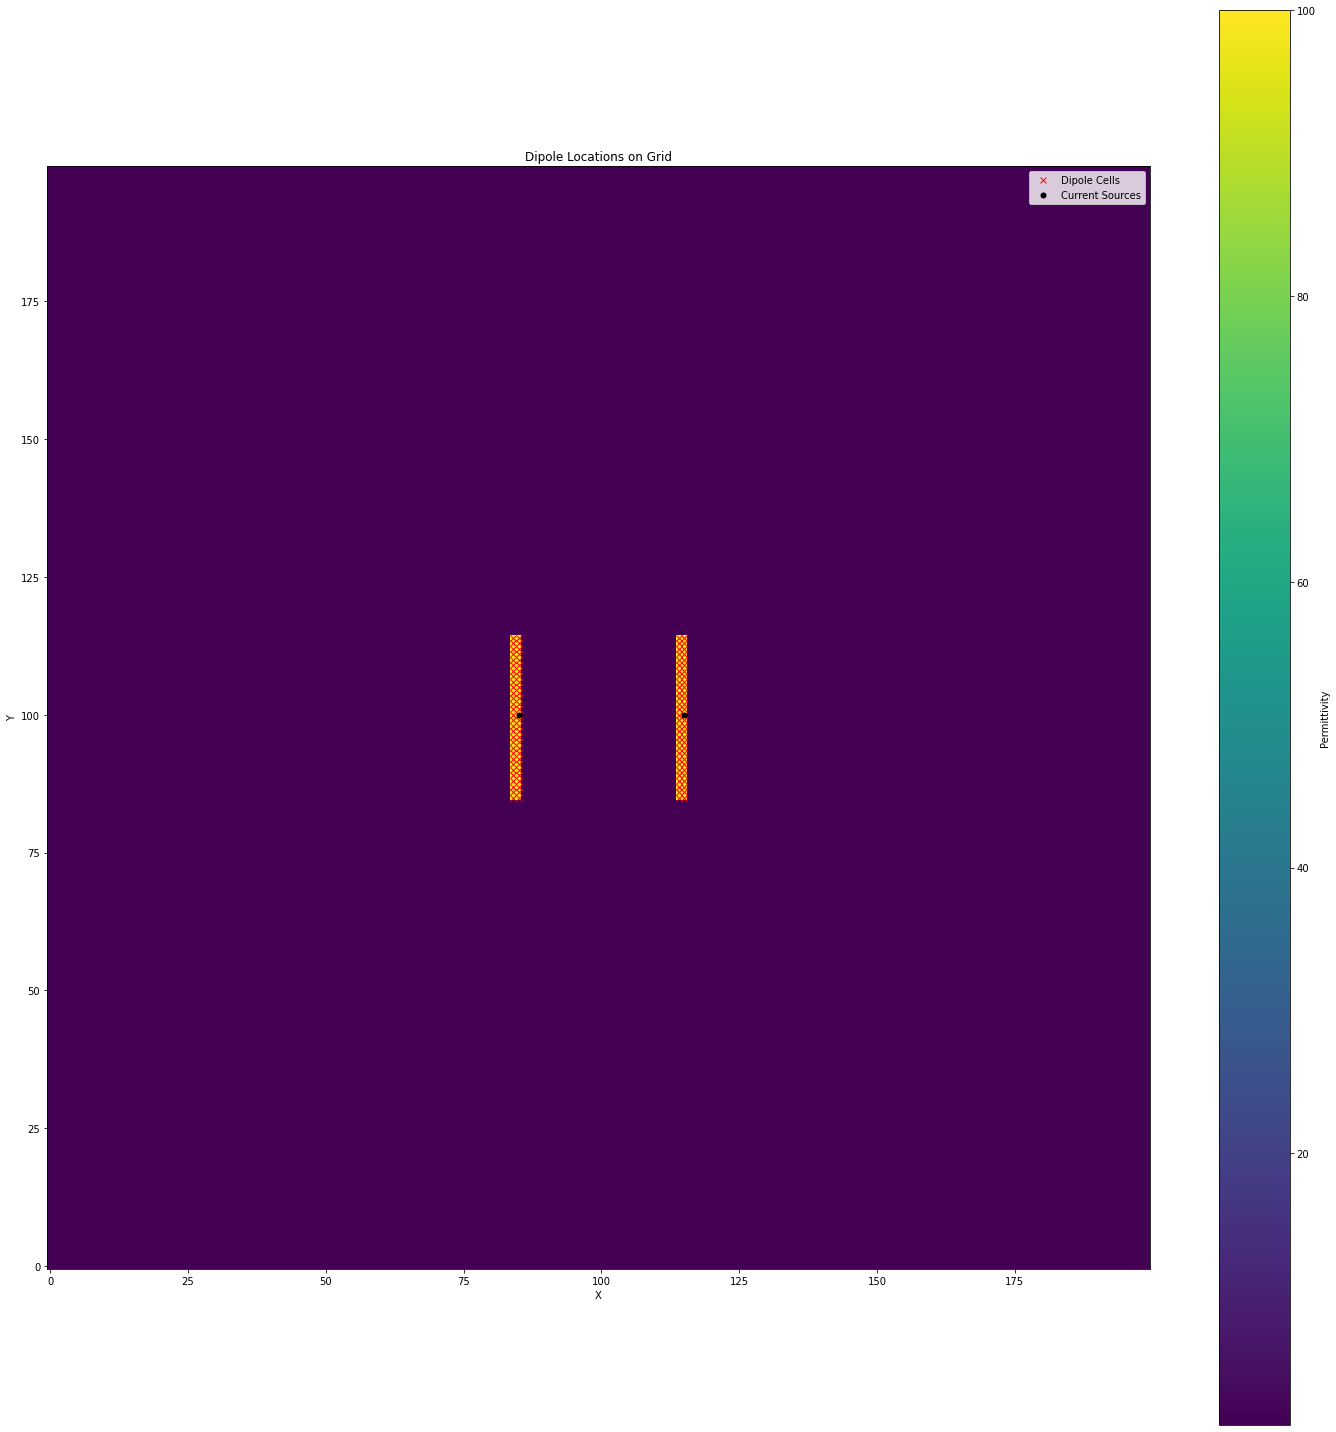

In [67]:
# Visualize grid setup to verify locations of everything

plt.figure(figsize=(20, 20))

# Plot the permittivity grid
plt.imshow(grid, cmap='viridis', origin= 'lower')
plt.colorbar(label='Permittivity')
plt.title('Dipole Locations on Grid')
plt.xlabel('X')
plt.ylabel('Y')

# Mark where the left dipole cells are with a 'x'.
for x in range(dipole1_left, dipole1_right + 1):
    for y in range(dipole1_bottom, dipole1_top + 1):
            plt.plot(x, y, 'x', color='red')

# Mark where the right dipole cells are with a 'x'.
for x in range(dipole2_left, dipole2_right + 1):
    for y in range(dipole2_bottom, dipole2_top + 1):
            plt.plot(x, y, 'x', color='red')

# Mark where the left current source is with a 'o'.
plt.plot(x1_source, y1_source, 'o', markersize = 5, color = 'black')

# Mark where the right current source is with a 'o'.
plt.plot(x2_source, y2_source, 'o', markersize = 5, color = 'black')

# had to add empty plots to get legend
plt.plot([], [], 'x', color='red', label="Dipole Cells")
plt.plot([], [], 'o', markersize=5, color='black', label="Current Sources")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

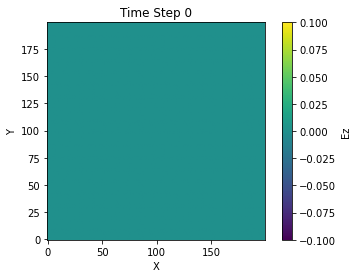

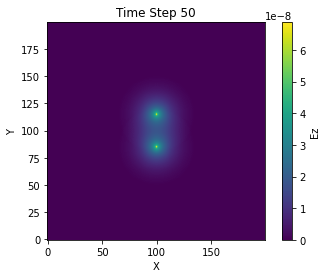

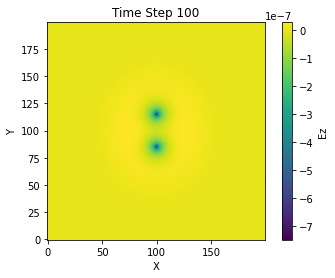

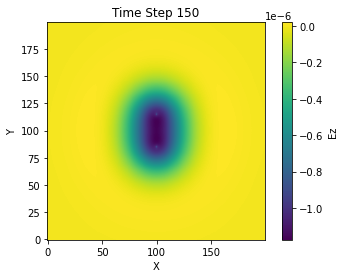

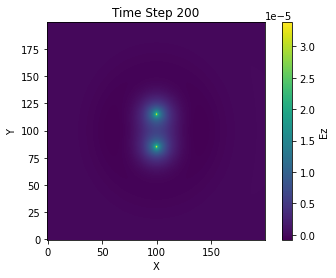

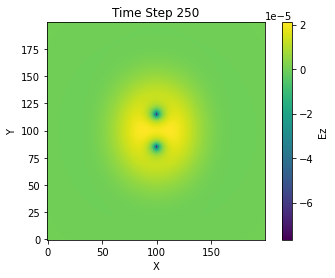

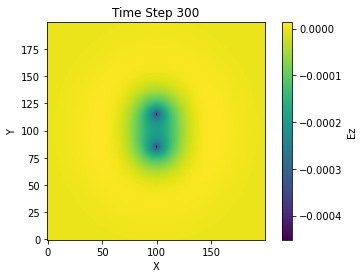

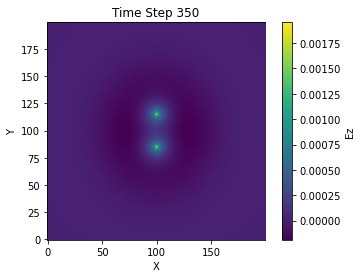

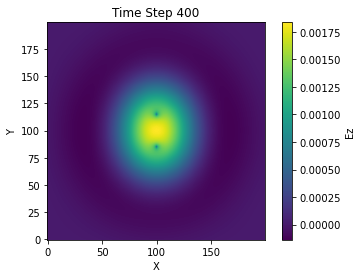

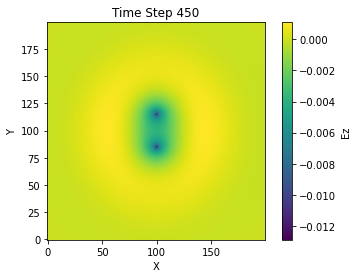

In [68]:
# 2D FDTD Model

# Using absorbing boundary condition to simulate the energy being absorbed in air.
boundaryLeft = np.zeros(numY_cells)
boundaryRight = np.zeros(numY_cells)
boundaryBottom = np.zeros(numX_cells)
boundaryTop = np.zeros(numX_cells)

# Main 2D FDTD Loop
for n in range(max_time_steps):

    # Compute Hy 
    for i in range(numX_cells - 1):
        for j in range(numY_cells):
            Hy[i, j] += (Ez[i + 1, j] - Ez[i, j]) * magic_time_step / dx

     # Compute Hx
    for i in range(numX_cells):
        for j in range(numY_cells - 1):
            Hx[i, j] -= (Ez[i, j + 1] - Ez[i, j]) * magic_time_step / dy


    # Use temp variables to store left and bottom Ez values sorta like a moving window; only 2 sides needed bc symmetrical
    tempLeft = Ez[1, :].copy() 
    tempBottom = Ez[:, 1].copy()  

    # Compute Ez
    for i in range(1, numX_cells - 1):
        for j in range(1, numY_cells - 1):
            Ez[i, j] += ((Hy[i, j] - Hy[i - 1, j]) * magic_time_step / dx) - ((Hx[i, j] - Hx[i, j - 1]) * magic_time_step / dy)

    
    # Apply excitation at left source
    t_n = n * magic_time_step
    Ez[x1_source, y1_source] += np.exp(-((t_n - 4 * sigma) ** 2) / sigma ** 2) * np.sin(omega0 * t_n)

    # Apply excitation at right source
    t_n = n * magic_time_step
    Ez[x2_source, y2_source] += np.exp(-((t_n - 4 * sigma) ** 2) / sigma ** 2) * np.sin(omega0 * t_n)

    # Update absorbing conditions
    Ez[0, :] = boundaryLeft
    Ez[-1, :] = boundaryRight
    Ez[:, 0] = boundaryBottom
    Ez[:, -1] = boundaryTop

    # Update boundary buffers for next time step
    boundaryLeft = tempLeft
    boundaryBottom = tempBottom
    boundaryRight = Ez[-2, :].copy()
    boundaryTop   = Ez[:, -2].copy()
    
    # Visualize Ez field every 50 time steps
    if n % 50 == 0:
        plt.clf() 
        plt.imshow(Ez, cmap='viridis', origin='lower')
        plt.title(f"Time Step {n}")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.colorbar(label="Ez")
        plt.pause(0.01) 

plt.show()